### This notebook is to look at delirium data closely, do some EDA.

## Imports

In [1]:
import sys
sys.path.append("..")

from collections import OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy
from sqlalchemy import func, select, desc
from sqlalchemy.sql.expression import and_

import config
from cyclops.orm import DB

2022-02-11 12:47:20,078 INFO  config          - Log file is /mnt/nfs/home/krishnanam/log.log
2022-02-11 12:47:20,150 INFO  cyclops.orm     - Log file is /mnt/nfs/home/krishnanam/log.log


## Load config, setup ORM

In [2]:
cfg = config.read_config("../configs/default/*.yaml")
db = DB(cfg)

## String constants

In [3]:
GENC_ID = "genc_id"
PATIENT_ID = "patient_id"
HOSPITAL_ID = "hospital_id"
AGE = "age"
GENDER = "gender"
UNIQUE_LAB_NAMES = "unique_lab_names"
UNIQUE_LAB_COUNTS = "unique_lab_counts"
LAB_TEST_NAME = "lab_test_name"
UNIQUE_VITALS_NAMES = "unique_vitals_names"
UNIQUE_VITALS_COUNTS = "unique_vitals_counts"
VITALS_NAME = "vitals_name"
DISCHARGE_DISPOSITION = "discharge_disposition"
DELIRIUM_LABEL = "del_present"
ADMIT_DATE_TIME = "admit_date_time"
DISCHARGE_DATE_TIME = "discharge_date_time"
MEDICATION_NAME = "medication_name"
UNIQUE_MEDS_NAMES = "unique_meds_names"
UNIQUE_MEDS_COUNTS = "unique_meds_counts"

## Delirium data distribution

Mean Age: Delirium present: 76.57520325203252, No delirium: 66.1254819488258


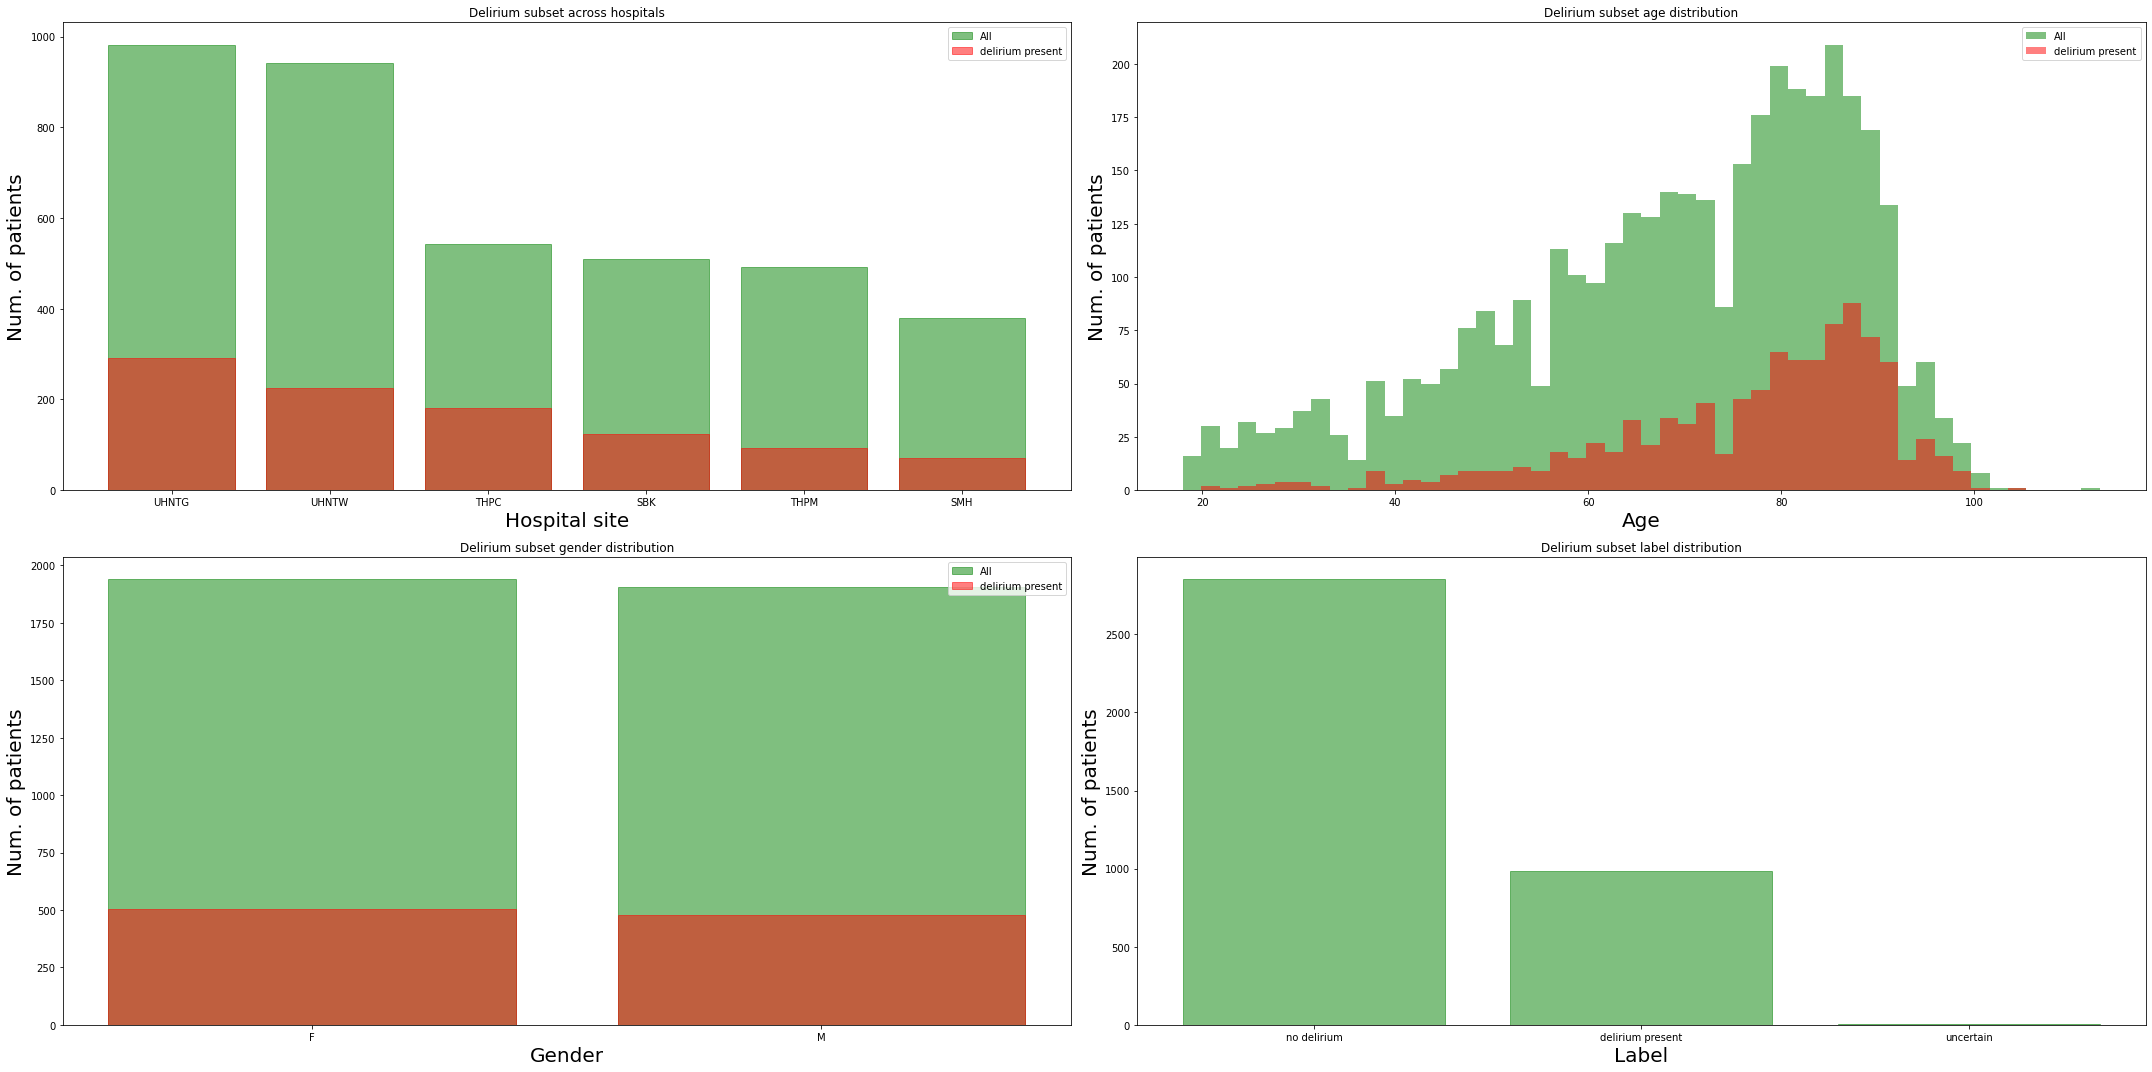

In [4]:
delirium_admin_query = select(db.public.ip_administrative.patient_id_hashed.label(PATIENT_ID),
                              db.public.ip_administrative.genc_id,
                              db.public.ip_administrative.hospital_id,
                              db.public.ip_administrative.admit_date_time,
                              db.public.ip_administrative.age,
                              db.public.ip_administrative.gender,
                              db.public.ip_administrative.discharge_date_time,
                              db.public.ip_administrative.discharge_disposition,
                              db.public.ip_administrative.del_present,
                              db.public.ip_administrative.gemini_cohort
                             ).where(db.public.ip_administrative.gemini_cohort == True).subquery()
admin_data = db.run_query(delirium_admin_query)
admin_data_pos = admin_data.loc[admin_data[DELIRIUM_LABEL] == 1]
admin_data_neg = admin_data.loc[admin_data[DELIRIUM_LABEL] == 2]


fig, axs = plt.subplots(2, 2, figsize=(30, 15), tight_layout=True)

# Across hospitals
hosp_counts = list(admin_data[HOSPITAL_ID].value_counts())
hospitals = list(admin_data[HOSPITAL_ID].unique())
hosp_counts_pos = list(admin_data_pos[HOSPITAL_ID].value_counts())

hosp_bars = axs[0][0].bar(hospitals, hosp_counts, alpha = 0.5)
for bar in hosp_bars:
    bar.set_color('g')
hosp_bars_pos = axs[0][0].bar(hospitals, hosp_counts_pos, alpha = 0.5)
for bar in hosp_bars_pos:
    bar.set_color('r')
axs[0][0].title.set_text("Delirium subset across hospitals")
axs[0][0].set_xlabel("Hospital site", fontsize=20)
axs[0][0].set_ylabel("Num. of patients", fontsize=20)
lgnd = ['All', 'delirium present']
axs[0][0].legend(lgnd, loc=1)

# Across age
ages = admin_data[AGE]
ages_pos = admin_data_pos[AGE]
ages_neg = admin_data_neg[AGE]
print(f"Mean Age: Delirium present: {np.array(ages_pos).mean()}, No delirium: {np.array(ages_neg).mean()}")

(_, bins, _) = axs[0][1].hist(ages, bins=50, alpha=0.5, color='g')
axs[0][1].hist(ages_pos, bins=bins, alpha=0.5, color='r')
axs[0][1].title.set_text("Delirium subset age distribution")
axs[0][1].set_xlabel("Age", fontsize=20)
axs[0][1].set_ylabel("Num. of patients", fontsize=20)
axs[0][1].legend(lgnd, loc=1)

# Across gender
genders = list(admin_data[GENDER].unique())
gender_counts = list(admin_data[GENDER].value_counts())
gender_counts_pos = list(admin_data_pos[GENDER].value_counts())

gender_bars = axs[1][0].bar(genders, gender_counts, alpha = 0.5)
for bar in gender_bars:
    bar.set_color('g')
gender_bars_pos = axs[1][0].bar(genders, gender_counts_pos, alpha = 0.5)
for bar in gender_bars_pos:
    bar.set_color('r')
axs[1][0].title.set_text("Delirium subset gender distribution")
axs[1][0].set_xlabel("Gender", fontsize=20)
axs[1][0].set_ylabel("Num. of patients", fontsize=20)
axs[1][0].legend(lgnd, loc=1)

# Across labels
DEL_LABEL_MAP = {
    1: "delirium present",
    2: "no delirium",
    3: "uncertain"
}
label_counts = admin_data[DELIRIUM_LABEL].value_counts().to_dict().values()
labels = admin_data[DELIRIUM_LABEL].value_counts().to_dict().keys()
labels = [DEL_LABEL_MAP[l] for l in labels]

label_bars = axs[1][1].bar(labels, label_counts, alpha = 0.5)
for bar in label_bars:
    bar.set_color('g')
axs[1][1].title.set_text("Delirium subset label distribution")
axs[1][1].set_xlabel("Label", fontsize=20)
axs[1][1].set_ylabel("Num. of patients", fontsize=20)


plt.show()

## Discharge disposition

                 variable value                  description
7   discharge_disposition     1       Acute Care Institution
8   discharge_disposition     2                        Other
9   discharge_disposition     3                        Other
10  discharge_disposition     4                         Home
11  discharge_disposition     5                         Home
12  discharge_disposition     6                         Home
13  discharge_disposition     7                         Died
14  discharge_disposition     8                        Other
15  discharge_disposition     9                        Other
16  discharge_disposition    12                         Home
17  discharge_disposition    10       Acute Care Institution
18  discharge_disposition    20         Transferred to other
19  discharge_disposition    30         Transferred to other
20  discharge_disposition    40         Transferred to other
21  discharge_disposition    90         Transferred to other
22  discharge_dispositio

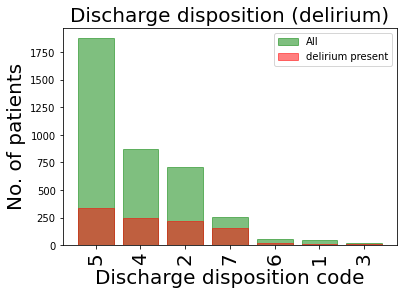

In [5]:
# Discharge disposition codes on GEMINI
lookup_query = select(db.public.lookup_ip_administrative.variable,
                      db.public.lookup_ip_administrative.value,
                      db.public.lookup_ip_administrative.description).subquery()
data = db.run_query(lookup_query)
data = data.loc[data["variable"] == DISCHARGE_DISPOSITION]
print(data)

# Longer descriptions taken from CIHI portal 
# https://www.cihi.ca/sites/default/files/document/cihi-portal-release-notes-release-13.1-en_en02jpdg.pdf
DISCHARGE_DISPOSITION_MAP = {
    1: "Transferred to acute inpatient institution (other acute, psych, etc.)",
    2: "Transferred continuing care (other facility or level of care in same)",
    3: "Transfer other (ambulatory/palliative, addiction/jail, child agency)",
    4: "Discharged to a home setting with support services (senior lodge, attendant care, home care . . .)",
    5: "Discharged home (no external support needed, not incl. nursing homes)",
    6: "Signed out (leaving against medical advice, AWOL)",
    7: "Died"
}
discharge_disposition_counts = admin_data[DISCHARGE_DISPOSITION].value_counts()
discharge_disposition_counts_pos = admin_data_pos[DISCHARGE_DISPOSITION].value_counts()
for disch_code, meaning in DISCHARGE_DISPOSITION_MAP.items():
    print(f"{meaning}: {discharge_disposition_counts[disch_code]}")

disch_disp_bars = plt.bar(list(range(len(discharge_disposition_counts))), discharge_disposition_counts.values, alpha = 0.5)
for bar in disch_disp_bars:
    bar.set_color('g')
disch_disp_bars_pos = plt.bar(list(range(len(discharge_disposition_counts_pos))), discharge_disposition_counts_pos.values, alpha = 0.5)
for bar in disch_disp_bars_pos:
    bar.set_color('r')
plt.xticks(range(len(discharge_disposition_counts)), discharge_disposition_counts.keys(), rotation='vertical', fontsize=20)
plt.title("Discharge disposition (delirium)", fontsize=20)
plt.xlabel("Discharge disposition code", fontsize=20)
plt.ylabel("No. of patients", fontsize=20)
lgnd = ['All', 'delirium present']
plt.legend(lgnd, loc=1)
plt.show()

# Fraction of people with delirium positive label, and disch. dispostion (7) - is significantly higher compared to others.

## Year of care, LOS distribution (delirium subset)

Mean LOS (days): Delirium present: 14.075203252032521, No delirium: 6.058885383806519


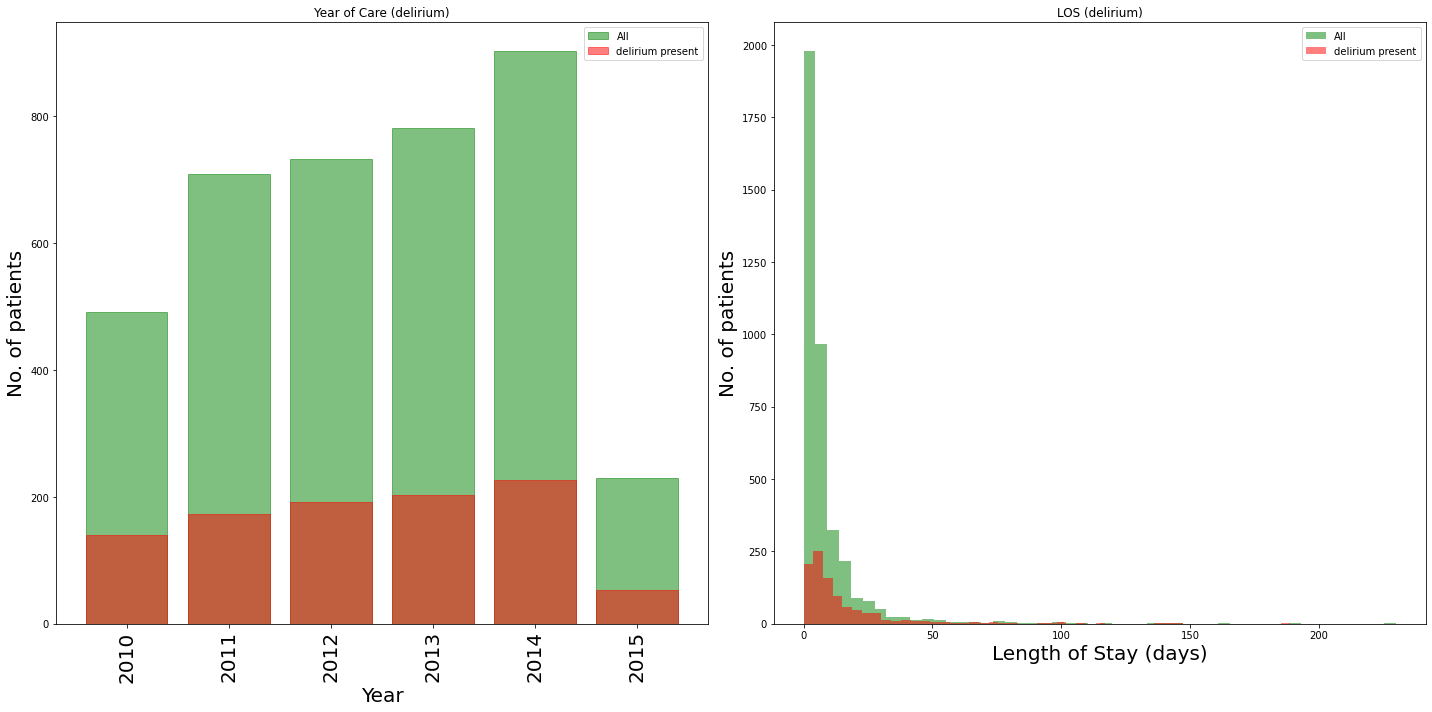

In [16]:
admit_discharge_times = admin_data[[ADMIT_DATE_TIME, DISCHARGE_DATE_TIME]]
years_counts = admit_discharge_times[ADMIT_DATE_TIME].dt.year.value_counts().to_dict()
years_counts = OrderedDict(sorted(years_counts.items()))

admit_discharge_times_pos = admin_data_pos[[ADMIT_DATE_TIME, DISCHARGE_DATE_TIME]]
years_counts_pos = admit_discharge_times_pos[ADMIT_DATE_TIME].dt.year.value_counts().to_dict()
years_counts_pos = OrderedDict(sorted(years_counts_pos.items()))

fig, axs = plt.subplots(1, 2, figsize=(20, 10), tight_layout=True)
lgnd = ['All', 'delirium present']

years_bars = axs[0].bar(list(range(len(years_counts))), years_counts.values(), alpha = 0.5)
for bar in years_bars:
    bar.set_color('g')
years_bars_pos = axs[0].bar(list(range(len(years_counts_pos))), years_counts_pos.values(), alpha = 0.5)
for bar in years_bars_pos:
    bar.set_color('r')
axs[0].set_xticks(range(len(years_counts)), years_counts.keys(), rotation='vertical', fontsize=20)
axs[0].title.set_text("Year of Care (delirium)")
axs[0].set_xlabel("Year", fontsize=20)
axs[0].set_ylabel("No. of patients", fontsize=20)
axs[0].legend(lgnd, loc=1)

los = admit_discharge_times[DISCHARGE_DATE_TIME] - admit_discharge_times[ADMIT_DATE_TIME]
los = los.astype('timedelta64[D]')
los_pos = admit_discharge_times_pos[DISCHARGE_DATE_TIME] - admit_discharge_times_pos[ADMIT_DATE_TIME]
los_pos = los_pos.astype('timedelta64[D]')
admit_discharge_times_neg = admin_data_neg[[ADMIT_DATE_TIME, DISCHARGE_DATE_TIME]]
los_neg = admit_discharge_times_neg[DISCHARGE_DATE_TIME] - admit_discharge_times_neg[ADMIT_DATE_TIME]
los_neg = los_neg.astype('timedelta64[D]')
print(f"Mean LOS (days): Delirium present: {np.array(los_pos).mean()}, No delirium: {np.array(los_neg).mean()}")
axs[1].hist(los, bins=50, alpha=0.5, color='g')
axs[1].hist(los_pos, bins=50, alpha=0.5, color='r')
axs[1].title.set_text("LOS (delirium)")
axs[1].set_xlabel("Length of Stay (days)", fontsize=20)
axs[1].set_ylabel("No. of patients", fontsize=20)
axs[1].legend(lgnd, loc=1)

plt.show()

## Find out top unique lab tests across GEMINI

In [7]:
"""Unique lab names and counts. Get top k lab tests ordered.

`lab_test_name_mapped` has common tests mapped across sites by GEMINI.
`lab_test_name_raw` has raw test names which are much greater in number (most different, unmapped across sites).
"""
k = 54

unique_lab_names = func.lower(db.public.lab.lab_test_name_mapped)
query = select(unique_lab_names.label(UNIQUE_LAB_NAMES),
               func.count(unique_lab_names).label(UNIQUE_LAB_COUNTS)
              )
query = query.group_by(UNIQUE_LAB_NAMES).order_by(desc(UNIQUE_LAB_COUNTS))

lab_counts = db.run_query(query)
print(f"Num. of unique lab tests: {len(lab_counts)}")
print(lab_counts.head(k))

Num. of unique lab tests: 55
                          unique_lab_names  unique_lab_counts
0                                   sodium            3043713
1                                potassium            2620534
2                               lymphocyte            2555905
3                               hemoglobin            2405465
4                               creatinine            2371876
5                              bicarbonate            2325705
6                   white blood cell count            2310123
7                           platelet count            2307750
8                   mean cell volume (mcv)            2299557
9                               hematocrit            2258974
10                             neutrophils            2193498
11                   glucose point of care            1840409
12                              urinalysis            1405597
13                          glucose random            1279665
14               blood urea nitrogen (bun

## Get the mapped lab tests for patients with delirium label

In [8]:
common_lab_tests = list(lab_counts.head(k)[UNIQUE_LAB_NAMES])
lab_test_name = func.lower(db.public.lab.lab_test_name_mapped)
lab_query = select(db.public.lab.genc_id,
                   lab_test_name.label(LAB_TEST_NAME),
                   db.public.lab.result_value,
                   db.public.lab.result_unit,
                   db.public.lab.sample_collection_date_time).subquery()
query = select(db.public.ip_administrative.patient_id_hashed.label(PATIENT_ID),
               db.public.ip_administrative.genc_id,
               db.public.ip_administrative.hospital_id,
               db.public.ip_administrative.admit_date_time,
               db.public.ip_administrative.discharge_date_time,
               db.public.ip_administrative.del_present,
               db.public.ip_administrative.gemini_cohort,
               lab_query.c.lab_test_name,
               lab_query.c.result_value,
               lab_query.c.result_unit,
               lab_query.c.sample_collection_date_time,
              ).join(lab_query,
                     db.public.ip_administrative.genc_id == lab_query.c.genc_id
                    ).where(and_(lab_query.c.lab_test_name.in_(common_lab_tests),
                                 db.public.ip_administrative.gemini_cohort == True))
labs = db.run_query(query)
print(labs[GENC_ID].nunique())

3837


## Plot distribution of lab tests ordered (delirium subset vs. all patients)

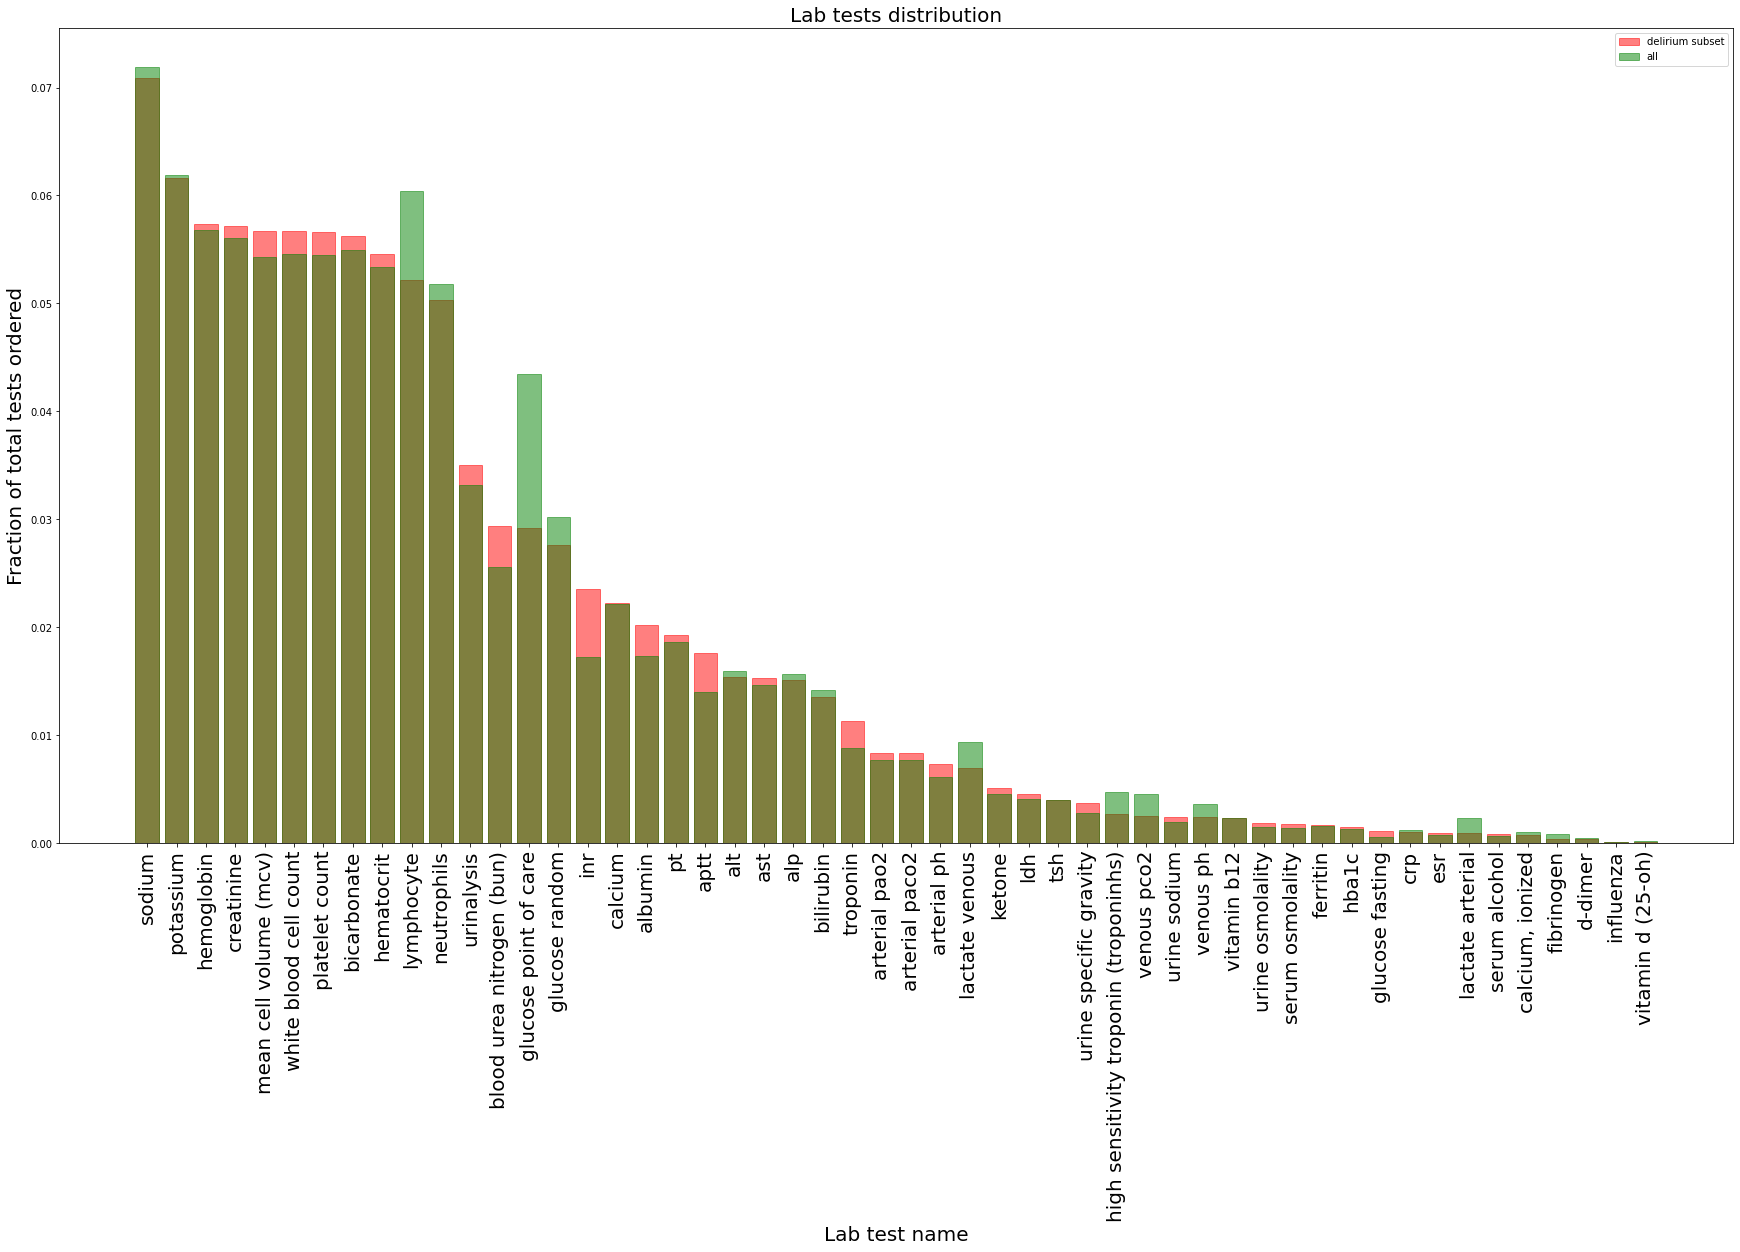

In [9]:
del_lab_names = labs[LAB_TEST_NAME].value_counts().keys()
del_lab_counts = labs[LAB_TEST_NAME].value_counts().values
del_lab_counts = np.array(del_lab_counts) / sum(del_lab_counts)

all_lab_counts = [int(lab_counts.loc[lab_counts[UNIQUE_LAB_NAMES] == ln][UNIQUE_LAB_COUNTS]) for ln in del_lab_names]
all_lab_counts = np.array(all_lab_counts) / sum(all_lab_counts)

fig = plt.figure(figsize=(30, 15))
delirum_labs_bars = plt.bar(list(range(len(del_lab_names))), del_lab_counts, alpha = 0.5)
for bar in delirum_labs_bars:
    bar.set_color('r')
all_labs_bars = plt.bar(list(range(len(del_lab_names))), all_lab_counts, alpha = 0.5)
for bar in all_labs_bars:
    bar.set_color('g')
plt.xticks(range(len(delirum_labs_bars)), del_lab_names, rotation='vertical', fontsize=20)
plt.title("Lab tests distribution", fontsize=20)
plt.xlabel("Lab test name", fontsize=20)
plt.ylabel("Fraction of total tests ordered", fontsize=20)

lgnd = ['delirium subset', 'all']
plt.legend(lgnd, loc=1)
plt.show()

## Lab tests distribution across sites (delirium).

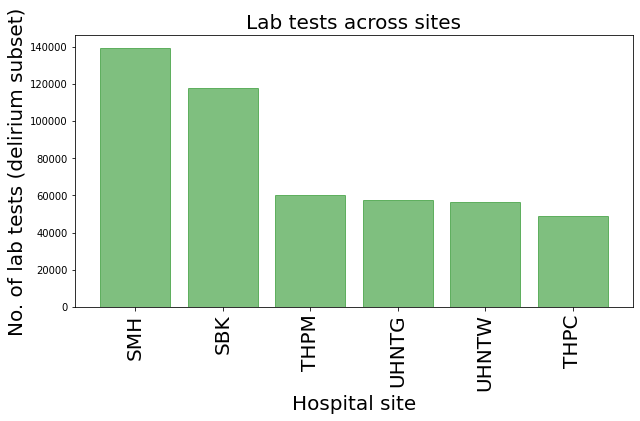

In [10]:
lab_counts_hosp = labs[HOSPITAL_ID].value_counts()
fig = plt.figure(figsize=(10, 5))
labs_hosp_bars = plt.bar(list(range(len(lab_counts_hosp))), lab_counts_hosp.values, alpha = 0.5)
for bar in labs_hosp_bars:
    bar.set_color('g')
plt.xticks(range(len(labs_hosp_bars)), lab_counts_hosp.keys(), rotation='vertical', fontsize=20)
plt.title("Lab tests across sites", fontsize=20)
plt.xlabel("Hospital site", fontsize=20)
plt.ylabel("No. of lab tests (delirium subset)", fontsize=20)
plt.show()

## TODO: Extract lab result values, units, aggregation

## Find out mapped/unique vital measurements

In [11]:
"""Unique vital measurement names and counts. Get top k vitals measured.

`measurement_mapped` has common vital measurements mapped across sites by GEMINI.
`measurement_name` has raw vitals names which are much greater in number (most different, unmapped across sites).
"""

k = 11

unique_vitals_names = func.lower(db.public.vitals.measurement_mapped)
query = select(unique_vitals_names.label(UNIQUE_VITALS_NAMES),
               func.count(unique_vitals_names).label(UNIQUE_VITALS_COUNTS)
              )
query = query.group_by(UNIQUE_VITALS_NAMES).order_by(desc(UNIQUE_VITALS_COUNTS))

vitals_counts = db.run_query(query)
print(f"Num. of unique vitals measurements: {len(vitals_counts)}")
print(vitals_counts.head(k))

Num. of unique vitals measurements: 12
   unique_vitals_names  unique_vitals_counts
0          temperature               1056374
1           heart rate                839616
2          systolic bp                837673
3         diastolic bp                837591
4    oxygen saturation                681903
5     respiratory rate                671321
6      oxygen_delivery                609249
7                  cam                472200
8                 fio2                445510
9     oxygen flow rate                335422
10              weight                120526


## Explore vitals data for delirium subset

In [12]:
common_vitals = list(vitals_counts.head(k)[UNIQUE_VITALS_NAMES])
vitals_name = func.lower(db.public.vitals.measurement_mapped)
vitals_query = select(db.public.vitals.genc_id,
                      vitals_name.label(VITALS_NAME)).subquery()
query = select(db.public.ip_administrative.patient_id_hashed.label(PATIENT_ID),
               db.public.ip_administrative.genc_id,
               db.public.ip_administrative.hospital_id,
               db.public.ip_administrative.del_present,
               db.public.ip_administrative.gemini_cohort,
               vitals_query.c.vitals_name,
              ).join(vitals_query,
                     db.public.ip_administrative.genc_id == vitals_query.c.genc_id
                    ).where(and_(vitals_query.c.vitals_name.in_(common_vitals),
                                 db.public.ip_administrative.gemini_cohort == True))
vitals = db.run_query(query)
print(vitals[GENC_ID].nunique())

# No vitals data for delirium subset??? Maybe ask why?

0


## Find out top unique medications across GEMINI

In [13]:
"""Unique medications names (raw) and counts. Get top k medications.

`med_id_generic_name_raw` has raw test names which are much greater in number (most different, unmapped across sites).
"""
k = 100

unique_meds_names = func.lower(db.public.pharmacy.med_id_generic_name_raw)
query = select(unique_meds_names.label(UNIQUE_MEDS_NAMES),
               func.count(unique_meds_names).label(UNIQUE_MEDS_COUNTS)
              )
query = query.group_by(UNIQUE_MEDS_NAMES).order_by(desc(UNIQUE_MEDS_COUNTS))

meds_counts = db.run_query(query)
print(f"Num. of unique medications: {len(meds_counts)}")
meds_counts = meds_counts.head(k)
meds_names_fixed = list(meds_counts[UNIQUE_MEDS_NAMES])[1:] # From index 1, since first one seems to be nameless.
meds_counts_fixed = list(meds_counts[UNIQUE_MEDS_COUNTS])[1:]

meds_counts = {}
for idx, meds_name in enumerate(meds_names_fixed):
    meds_counts[meds_name] = meds_counts_fixed[idx]

Num. of unique medications: 6752


## Plot distribution of medications (delirium subset vs. all patients)

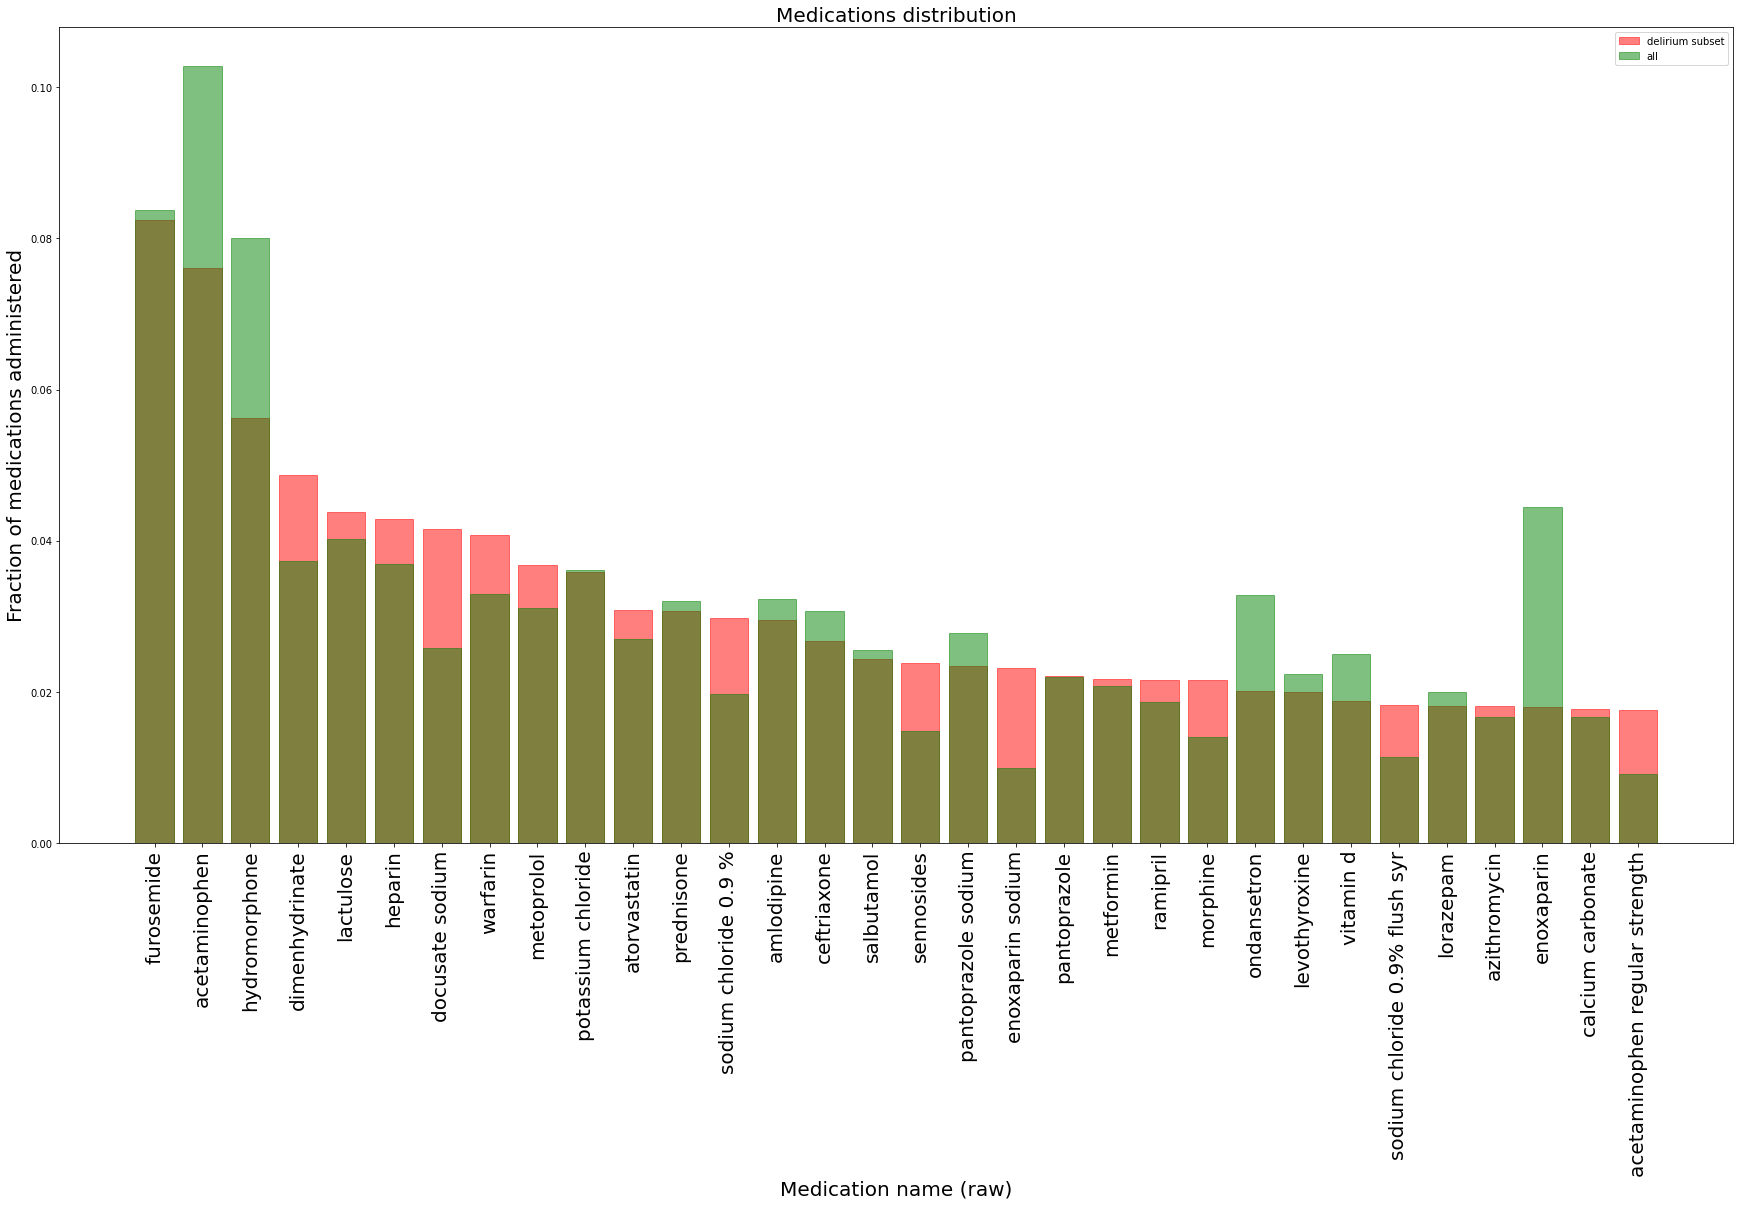

In [14]:
k = 33
medication_name = func.lower(db.public.pharmacy.med_id_generic_name_raw)
pharmacy_query = select(db.public.pharmacy.x,
                        medication_name.label(MEDICATION_NAME)).subquery()
query = select(db.public.ip_administrative.patient_id_hashed.label(PATIENT_ID),
               db.public.ip_administrative.genc_id,
               db.public.ip_administrative.hospital_id,
               db.public.ip_administrative.del_present,
               db.public.ip_administrative.gemini_cohort,
               pharmacy_query
              ).join(pharmacy_query,
                     db.public.ip_administrative.genc_id == pharmacy_query.c.genc_id
                    ).where(db.public.ip_administrative.gemini_cohort == True)
pharmacy_data = db.run_query(query)
del_meds_counts = pharmacy_data[MEDICATION_NAME].value_counts().head(k).to_dict()
del_meds_counts.pop('') # Seems to be an entry with no name.
del_meds_counts_values = np.array(list(del_meds_counts.values())) / sum(del_meds_counts.values())

fig = plt.figure(figsize=(30, 15))
del_meds_bars = plt.bar(list(range(len(del_meds_counts))), del_meds_counts_values, alpha = 0.5)
for bar in del_meds_bars:
    bar.set_color('r')
meds_counts_mapped = [meds_counts[med_name] for med_name in del_meds_counts.keys()]
meds_counts_mapped = np.array(meds_counts_mapped) / sum(meds_counts_mapped)
all_meds_bars = plt.bar(list(range(len(meds_counts_mapped))), meds_counts_mapped, alpha = 0.5)
for bar in all_meds_bars:
    bar.set_color('g')

plt.xticks(range(len(del_meds_bars)), del_meds_counts.keys(), rotation='vertical', fontsize=20)
plt.title("Medications distribution", fontsize=20)
plt.xlabel("Medication name (raw)", fontsize=20)
plt.ylabel("Fraction of medications administered", fontsize=20)

lgnd = ['delirium subset', 'all']
plt.legend(lgnd, loc=1)
plt.show()